# Network

This notebook explores the reduced network model included with PyPSA-GB. The reduced network model is a 29 bus and 99 line representation of the high voltage AC transmission network of the Great Britain (GB) electricity system.

Interconnections to other countries are also included for historical years. For future years the pipeline up to 2030 is included, and these are scaled to match projected interconnector capacities.

## Voronoi cells

Generators are connected to the buses by calculating the nearest bus by distance. Voronoi cells have been generated for the diagram below to illustrate the areas which correspond to the nearest bus. Voronoi cells show regions where all the points in one region are closer to one bus than any other bus.

In [2]:
import os
import sys
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

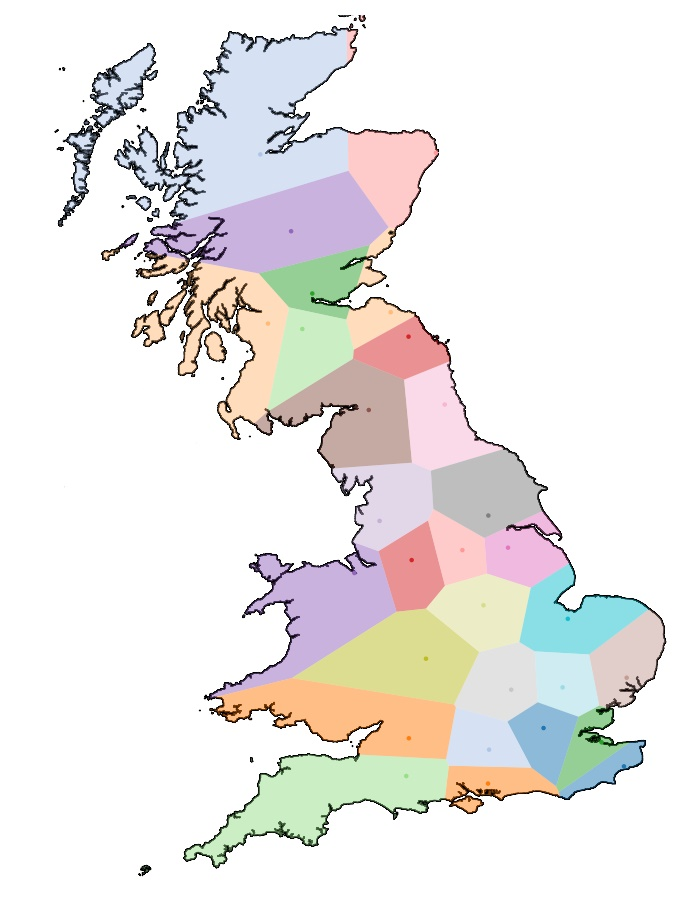

In [3]:
file = '../pics/voronoi_reduced_model.png'
from IPython.display import Image
Image(filename=file)

## Reduced network GB

The reduced GB network has been adapted from the openly available Reduced GB Network which was developed at the University of Strathclyde in 2010 (https://www.maths.ed.ac.uk/optenergy/NetworkData/reducedGB/). The main change is the addition of the Western HVDC link which strengthens the connection between Scotland and England, as well as upgrades of various lines.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature

import imageio

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point

from statistics import mean

Data for the buses and lines is read in...

In [5]:
df_network = pd.read_csv('../data/network/buses.csv')
lon = df_network['x'].values
lat = df_network['y'].values
coordinates = np.zeros(shape=(len(lon), 2))
for i in range(len(lon)):
    coordinates[i][0] = lon[i]
    coordinates[i][1] = lat[i]

df_lines = pd.read_csv('../data/network/lines.csv', index_col=0)
df_buses = pd.read_csv('../data/network/buses.csv', index_col=0)

The coordinates of the buses between lines is extracted for plotting. 

In [6]:
line_coordinates = []
for i in range(len(df_lines['bus0'].values)):

    bus0 = df_lines['bus0'].iloc[i]
    bus1 = df_lines['bus1'].iloc[i]
    bus0_coord = [df_buses['x'][bus0], df_buses['y'][bus0]]
    bus1_coord = [df_buses['x'][bus1], df_buses['y'][bus1]]
    line_coordinates.append([bus0_coord, bus1_coord])

This data is plotted using the geo package cartopy and plotting package matplotlib which is used extensively in this documentation.

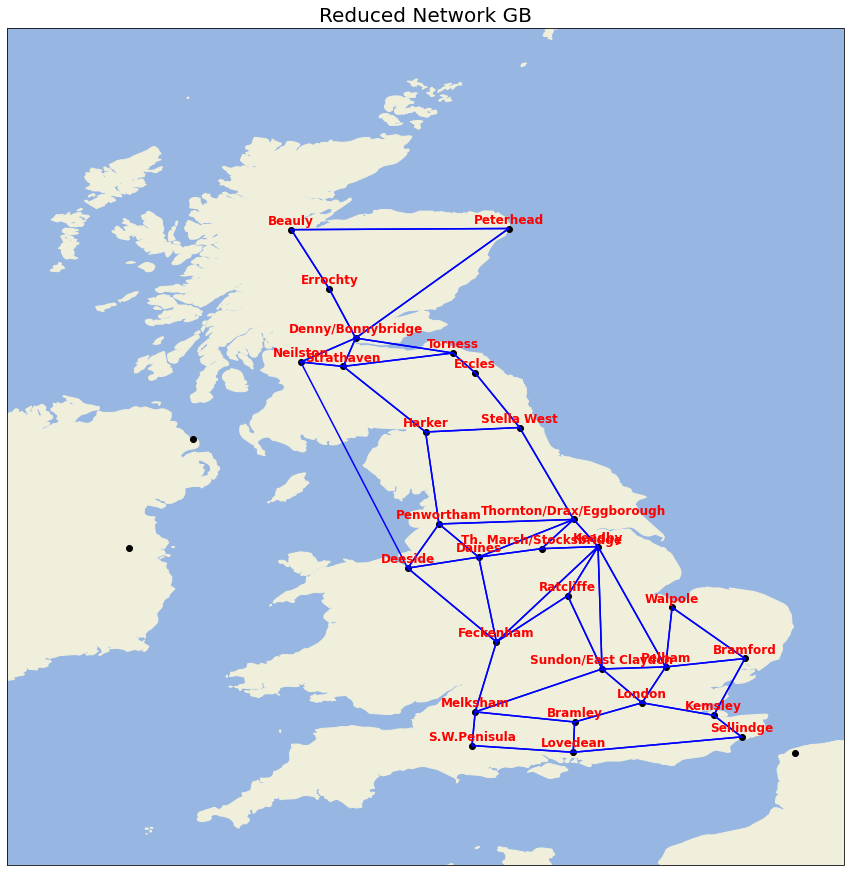

In [7]:
fig = plt.figure()
fig.set_size_inches(15, 17)
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

extent = [-8.09782, 2.40511, 60, 49.5]
ax.set_extent(extent)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)


for i in range(len(df_lines['bus0'].values)):
    ax.plot([line_coordinates[i][0][0], line_coordinates[i][1][0]],
            [line_coordinates[i][0][1], line_coordinates[i][1][1]],
            c='blue')

# ax.scatter(lon, lat, s=sizes * marker_scaler, c='black', edgecolors='black')
ax.scatter(lon, lat, c='black', edgecolors='black')
for i, txt in enumerate(df_buses[:29].index):
    ax.annotate(txt, (lon[i], lat[i]),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                fontweight='extra bold',
                color='red',
                fontsize='large')

ax.set_title('Reduced Network GB', fontsize=20)

plt.show()

This shows the underlying bus data.

In [8]:
df_buses.iloc[:29, :]

,v_nom,carrier,x,y
name,,,,
Beauly,275,AC,-4.533299,57.469876
Peterhead,275,AC,-1.804331,57.484481
Errochty,132,AC,-4.054907,56.724571
Denny/Bonnybridge,275,AC,-3.725282,56.109237
Neilston,400,AC,-4.414788,55.808831
Strathaven,400,AC,-3.880268,55.753988
Torness,400,AC,-2.507448,55.922401
Eccles,400,AC,-2.229827,55.677255
Harker,400,AC,-2.847820,54.931176


This shows the underlying line data.

In [9]:
df_lines

,bus0,bus1,r,x,b,s_nom
name,,,,,,
0,Beauly,Peterhead,0.01220,0.02000,0.0856,525
1,Beauly,Errochty,0.00700,0.15000,0.0520,132
2,Beauly,Peterhead,0.01220,0.02000,0.2844,525
3,Beauly,Errochty,0.00700,0.15000,0.0520,132
4,Peterhead,Denny/Bonnybridge,0.00040,0.06500,0.4454,760
...,...,...,...,...,...,...
94,Sellindge,Kemsley,0.00020,0.00503,0.1797,3100
95,Lovedean,Sellindge,0.00038,0.00711,0.2998,3070
96,Lovedean,Sellindge,0.00038,0.00711,0.2998,3070


## Interconnectors

The historical years model interconnectors as fixed import/export from historical data. There are 6 existing interconnectors and their use is reflected in the historical data. Interconnectors which have only recently become operational, such as IFA2 which begun operation in January 2021, will not be operational before that date in the model and will have fixed zero imports/exports.

In [10]:
df_interconnectors = pd.read_csv('../data/interconnectors/links.csv', index_col=0)
df_interconnectors

,bus0,bus1,carrier,p_nom
name,,,,
BritNed,Netherlands,Kemsley,DC,1000
EastWest,Ireland,Deeside,DC,600
Moyle,N. Ireland,Neilston,DC,600
Nemo,Belgium,Sellindge,DC,1000
IFA,France1,Sellindge,DC,2000
IFA2,France2,Lovedean,DC,1000


The interconnectors are plotted alongside the reduced network model below.

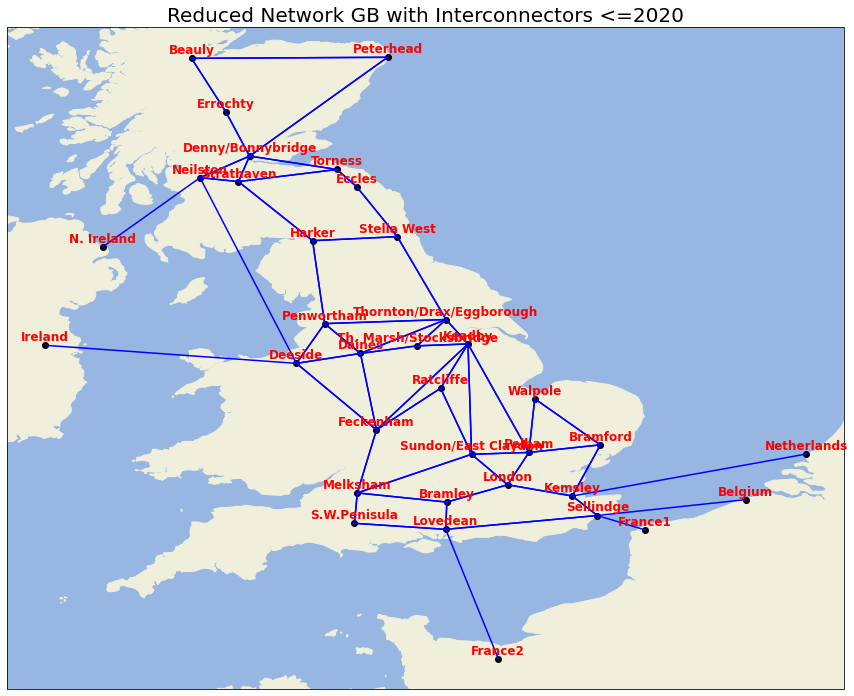

In [11]:
df_lines = pd.read_csv('../data/network/lines.csv', index_col=0)
df_buses = pd.read_csv('../data/network/buses.csv', index_col=0)

# append the interconnector data
df_lines_interconnectors = df_lines.append(df_interconnectors)

line_coordinates = []
for i in range(len(df_lines_interconnectors['bus0'].values)):

    bus0 = df_lines_interconnectors['bus0'].iloc[i]
    bus1 = df_lines_interconnectors['bus1'].iloc[i]
    bus0_coord = [df_buses['x'][bus0], df_buses['y'][bus0]]
    bus1_coord = [df_buses['x'][bus1], df_buses['y'][bus1]]
    line_coordinates.append([bus0_coord, bus1_coord])

line_coordinates

fig = plt.figure()
fig.set_size_inches(15, 17)
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)

for i in range(len(df_lines_interconnectors['bus0'].values)):
    ax.plot([line_coordinates[i][0][0], line_coordinates[i][1][0]],
            [line_coordinates[i][0][1], line_coordinates[i][1][1]],
            c='blue')

# ax.scatter(lon, lat, s=sizes * marker_scaler, c='black', edgecolors='black')
ax.scatter(lon, lat, c='black', edgecolors='black')
for i, txt in enumerate(df_buses.index):
    ax.annotate(txt, (lon[i], lat[i]),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                fontweight='extra bold',
                color='red',
                fontsize='large')

ax.set_title('Reduced Network GB with Interconnectors <=2020', fontsize=20)

plt.show()

## Future interconnectors

Future interconnectors are modelled as bi-directional controllable links with fixed marginal costs (see PyPSA documentation). The pipeline of interconnector projects can be found up to 2030 and is shown below, along with assumptions for marginal costs.

In [12]:
df_interconnectors_future = pd.read_csv('../data/interconnectors/links_future.csv', index_col=0)
df_interconnectors_future

,bus0,bus1,carrier,p_nom,installed date,marginal_cost
name,,,,,,
BritNed,Netherlands,Kemsley,DC,1000,01/01/2020,20
EastWest,Ireland,Deeside,DC,600,01/01/2020,7
Moyle,N. Ireland,Neilston,DC,600,01/01/2020,7
Nemo,Belgium,Sellindge,DC,1000,01/01/2020,20
IFA,France1,Sellindge,DC,2000,01/01/2020,15
IFA2,France2,Lovedean,DC,1000,01/01/2020,15
NSL,Norway,Stella West,DC,1400,01/01/2021,1
ElecLink,France1,Sellindge,DC,1000,01/01/2022,15
Viking Link,Denmark,Walpole,DC,1400,01/01/2023,7


Future interconnectors are plotted alongside the reduced network model and current interconnectors below.

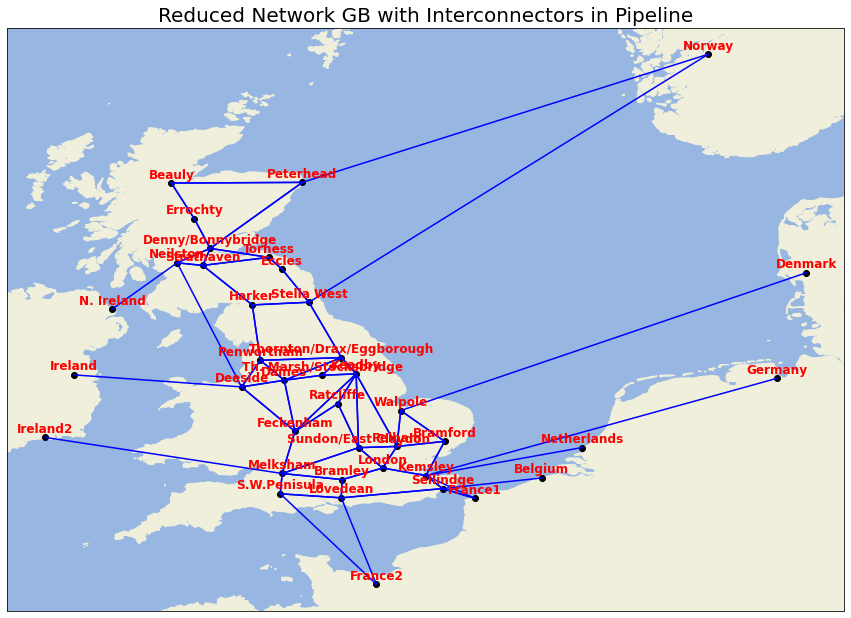

In [13]:
df_lines = pd.read_csv('../data/network/lines.csv', index_col=0)
df_buses = pd.read_csv('../data/network/buses.csv', index_col=0)

# append new buses
df_buses_future = pd.read_csv('../data/interconnectors/links_new_buses.csv', index_col=0)
df_buses = df_buses.append(df_buses_future)
# drop duplicate index incase future are already included
df_buses = df_buses[~df_buses.index.duplicated(keep='first')]
lon = df_buses['x'].values
lat = df_buses['y'].values

# append the interconnector data
df_lines_interconnectors = df_lines.append(df_interconnectors_future).reset_index()

line_coordinates = []
for i in range(len(df_lines_interconnectors['bus0'].values)):

    bus0 = df_lines_interconnectors['bus0'].iloc[i]
    bus1 = df_lines_interconnectors['bus1'].iloc[i]
    bus0_coord = [df_buses['x'][bus0], df_buses['y'][bus0]]
    bus1_coord = [df_buses['x'][bus1], df_buses['y'][bus1]]
    line_coordinates.append([bus0_coord, bus1_coord])

fig = plt.figure()
fig.set_size_inches(15, 25)
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)


for i in range(len(df_lines_interconnectors['bus0'].values)):
    ax.plot([line_coordinates[i][0][0], line_coordinates[i][1][0]],
            [line_coordinates[i][0][1], line_coordinates[i][1][1]],
            c='blue')

# ax.scatter(lon, lat, s=sizes * marker_scaler, c='black', edgecolors='black')
ax.scatter(lon, lat, c='black', edgecolors='black')
for i, txt in enumerate(df_buses.index):
    ax.annotate(txt, (lon[i], lat[i]),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                fontweight='extra bold',
                color='red',
                fontsize='large')

ax.set_title('Reduced Network GB with Interconnectors in Pipeline', fontsize=20)

plt.show()